<a href="https://colab.research.google.com/github/mSounak/Food-Vision/blob/master/FoodVision_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Downgrading Tensorflow for mixed precision
# !pip install tensorflow==2.4.1

In [2]:
# Check tensorflow version
import tensorflow as tf
tf.__version__

'2.4.1'

In [3]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1392ffb3-bfee-6bd1-5bb7-796544abdeb3)


In [4]:
# Download helper function
!wget https://raw.githubusercontent.com/mSounak/Food-Vision/master/helper_functions.py

--2021-07-05 16:16:40--  https://raw.githubusercontent.com/mSounak/Food-Vision/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10127 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.89K  --.-KB/s    in 0s      

2021-07-05 16:16:40 (96.8 MB/s) - ‘helper_functions.py’ saved [10127/10127]



In [5]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [6]:
# Get tensorflow datasets
import tensorflow_datasets as tfds

In [7]:
# List all available datasets
datasets_list = tfds.list_builders()    # get all the available datasets in TFDS
print("food101" in datasets_list)       # is our target dataset is available in TFDS dataset?

True


In [8]:
# Load in the data (takes 5-6 minutes. Data is around 5GB)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=['train', 'validation'],
                                            #  shuffle_files=True,
                                             as_supervised=True,                # data gets returned in tuple format (data, label)
                                             with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteE6SWYA/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteE6SWYA/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [9]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
# Take one sample of the train data
train_one_sample = train_data.take(1)       # samples are in format (image_tensor, label)

In [12]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [13]:
# Output info about our training example
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape},
    Image dtype: {image.dtype},
    Target class from Food101 (tensor form): {label},
    Class name (str form): {class_names[label]}
    """)


    Image shape: (512, 512, 3),
    Image dtype: <dtype: 'uint8'>,
    Target class from Food101 (tensor form): 56,
    Class name (str form): huevos_rancheros
    


In [14]:
# What does our image tensor look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [15]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

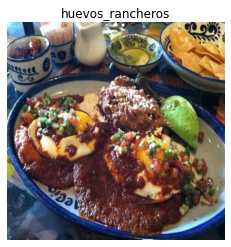

In [16]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False);

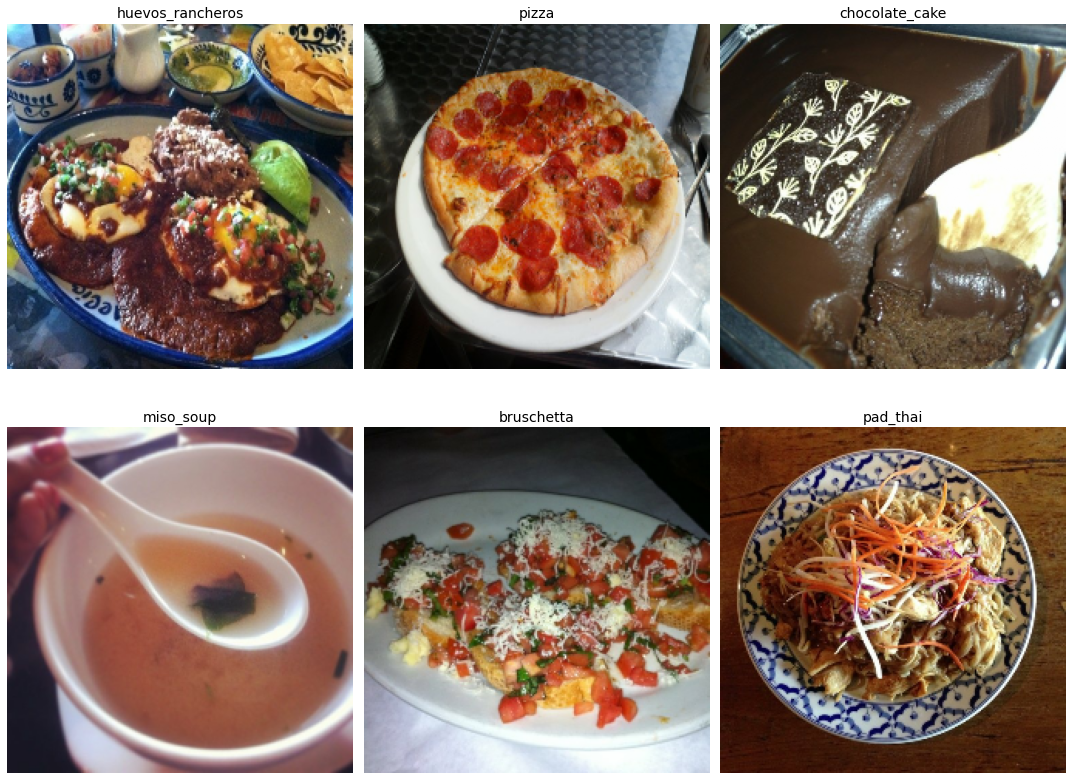

In [17]:
# Let's Create a function for visualisation

def plot_random_img(num, image_shape=(224,224)):
    train_data_samples = train_data.take(num)
    n = tf.math.ceil(num/3)
    plt.figure(figsize=(15,13), tight_layout=True)
    i=0
    for image, label in train_data_samples:
        img = tf.image.resize(image, image_shape)
        plt.subplot(n.numpy(), 3, i+1)
        plt.imshow(img/255.)
        plt.title(class_names[label.numpy()], fontsize=14)
        plt.axis(False)
        i=i+1

plot_random_img(num=6)

In [18]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=(224, 224)):
    
    img = tf.image.resize(image, size=img_shape)        # reshape target image
    return tf.cast(img, tf.float32), label            # return (float32_image, label) tuple 

In [19]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"""
Image before preprocessing:
{image[:2]}...,
Shape: {image.shape},
DataType: {image.dtype}
""")

print(f"""
Image after preprocessing:
{preprocessed_img[:2]}...,
Shape: {preprocessed_img.shape},
DataType: {preprocessed_img.dtype}
""")


Image before preprocessing:
[[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3),
DataType: <dtype: 'uint8'>


Image after preprocessing:
[[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]...,
Shape: (224, 224, 3),
DataType: <dtype: 'float32'>



In [20]:
y_labels = []
for _,labels in test_data:
  y_labels.append(labels.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [21]:
# Map preprocessing functions to training (and parallelize it)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data_batched = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
train_data, test_data_batched

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [23]:
# Create tensorboard callback (import from helper_function.py)
from helper_functions import create_tensorboard_callback

# Create a ModelCheckpoint callback
checkpoint_path = 'model_checkpoint/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      verbose=0,
                                                      save_best_only=True,
                                                      save_weights_only=True)

In [24]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")      # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [25]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

16711680/16705208 [==============================] - 0s 0us/step


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [27]:
# Check what dtype each of the layer is
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [28]:
# Check the dtype_policy for layers in the base model
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <

In [29]:
# Fit the feature extraction model with callbacks
history_feature_extraction = model.fit(train_data,
                                       epochs=5,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data_batched,
                                       validation_steps=int(0.15 * len(test_data_batched)),
                                       callbacks=[model_checkpoint,
                                                  create_tensorboard_callback(dir_name='training_log',
                                                                              experiment_name='ENB0_feature_extraction')])

Saving TensorBoard log files to: training_log/ENB0_feature_extraction/20210705-162845
Epoch 1/5
2368/2368 [==============================] - 250s 90ms/step - loss: 2.3373 - accuracy: 0.4622 - val_loss: 1.2289 - val_accuracy: 0.6764
Epoch 2/5
2368/2368 [==============================] - 201s 84ms/step - loss: 1.3311 - accuracy: 0.6571 - val_loss: 1.1307 - val_accuracy: 0.6978
Epoch 3/5
2368/2368 [==============================] - 170s 70ms/step - loss: 1.1658 - accuracy: 0.6946 - val_loss: 1.0974 - val_accuracy: 0.7039
Epoch 4/5
2368/2368 [==============================] - 159s 66ms/step - loss: 1.0648 - accuracy: 0.7210 - val_loss: 1.0776 - val_accuracy: 0.7090
Epoch 5/5
2368/2368 [==============================] - 158s 66ms/step - loss: 0.9887 - accuracy: 0.7399 - val_loss: 1.0696 - val_accuracy: 0.7132


In [30]:
# Evaluate model on whole data set
result_feature_extraction_model = model.evaluate(test_data_batched)

790/790 [==============================] - 58s 73ms/step - loss: 1.0724 - accuracy: 0.7091


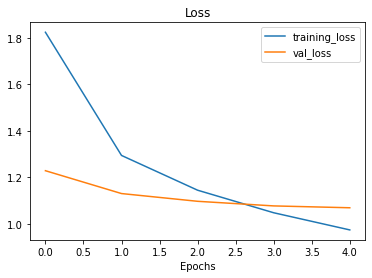

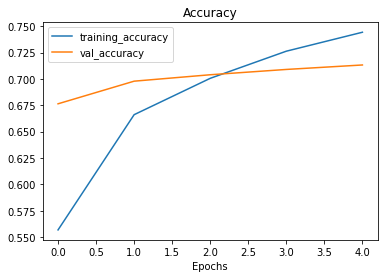

In [31]:
# Plot the loss curve
from helper_functions import plot_loss_curves
plot_loss_curves(history_feature_extraction)

In [32]:
# Save model locally
model.save('Food-big_feature_extraction')

INFO:tensorflow:Assets written to: Food-big_feature_extraction/assets


INFO:tensorflow:Assets written to: Food-big_feature_extraction/assets


In [33]:
# Load model
loaded_model = tf.keras.models.load_model('Food-big_feature_extraction')

In [34]:
# Check the layers in the base model and see what dtype policy they are using
for layer in loaded_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [35]:
# Check the loaded model performance
result_loaded_model = loaded_model.evaluate(test_data_batched)

790/790 [==============================] - 47s 58ms/step - loss: 1.0724 - accuracy: 0.7091


In [36]:
# Loaded model's result compared to feature extraction model's result
import numpy as np
np.isclose(result_loaded_model, result_feature_extraction_model)

array([ True,  True])

In [37]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [38]:
for layer in loaded_model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [39]:
print(len(loaded_model.layers[1].trainable_variables))

211


In [40]:
# Setting up EarlyStopping Callback
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=3)
# Setting up model's check point
checkpoint_path = 'model_checkpoint/cp_fine_tune.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_loss',
                                                      save_best_only=True)
                                                    
# Setting up ReduceLROnPlateau Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, verbose=1, min_lr=1e-7)       

In [41]:
# Compile the model
loaded_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=['accuracy'])

In [42]:
# loaded model summary
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [43]:
# Fit the model for fine tuning
history_fine_tune = loaded_model.fit(train_data,
                                     epochs=100,
                                     steps_per_epoch=len(train_data),
                                     validation_data=test_data_batched,
                                     validation_steps=int(0.15 * len(test_data_batched)),
                                     callbacks=[earlystopping_callback,
                                                model_checkpoint, reduce_lr,
                                                create_tensorboard_callback(dir_name='training_log',
                                                                            experiment_name='ENBO_fine_tune_30_layers')])

Saving TensorBoard log files to: training_log/ENBO_fine_tune_30_layers/20210705-164654
Epoch 1/100
2368/2368 [==============================] - 301s 122ms/step - loss: 0.9201 - accuracy: 0.7501 - val_loss: 0.8552 - val_accuracy: 0.7701
INFO:tensorflow:Assets written to: model_checkpoint/cp_fine_tune.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoint/cp_fine_tune.ckpt/assets


Epoch 2/100
2368/2368 [==============================] - 286s 120ms/step - loss: 0.5477 - accuracy: 0.8486 - val_loss: 0.9132 - val_accuracy: 0.7590
Epoch 3/100
2368/2368 [==============================] - 287s 119ms/step - loss: 0.3025 - accuracy: 0.9145 - val_loss: 0.9886 - val_accuracy: 0.7709

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/100
2368/2368 [==============================] - 287s 120ms/step - loss: 0.1057 - accuracy: 0.9718 - val_loss: 1.0717 - val_accuracy: 0.7903


In [44]:
# Evaluate our model on whole dataset
result_fine_tune = loaded_model.evaluate(test_data_batched)

790/790 [==============================] - 58s 74ms/step - loss: 1.0591 - accuracy: 0.7880


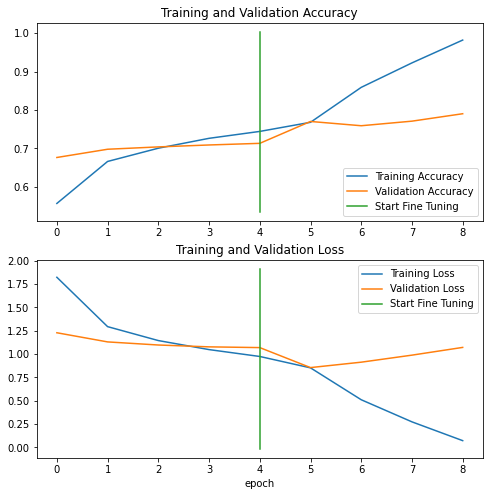

In [45]:
# Compare history
from helper_functions import compare_historys
compare_historys(history_feature_extraction, history_fine_tune)

In [46]:
# Saving the model locally
loaded_model.save('/content/SavedModel/Food-Big-Fine-tune')

INFO:tensorflow:Assets written to: /content/SavedModel/Food-Big-Fine-tune/assets


INFO:tensorflow:Assets written to: /content/SavedModel/Food-Big-Fine-tune/assets


In [47]:
probs = loaded_model.predict(test_data_batched)
probs[:10]

array([[2.7064618e-04, 1.9019608e-12, 2.2907520e-09, ..., 6.4516433e-07,
        2.0976973e-10, 1.8894147e-04],
       [1.2991282e-10, 1.3557619e-12, 2.4794295e-11, ..., 3.6075486e-11,
        3.8948226e-08, 1.3215743e-13],
       [2.1132074e-12, 5.7442931e-12, 9.1408374e-14, ..., 1.1670239e-12,
        4.1139012e-11, 1.8465000e-13],
       ...,
       [1.6052280e-09, 4.1849879e-14, 1.2817273e-12, ..., 1.9881687e-15,
        5.3736309e-14, 1.9851781e-12],
       [6.7446036e-16, 8.6109319e-15, 2.3044050e-14, ..., 1.3546897e-14,
        2.9500196e-08, 1.3000562e-15],
       [4.3479897e-02, 2.9910419e-09, 7.2162248e-10, ..., 6.9189147e-04,
        5.2874556e-13, 3.2253286e-01]], dtype=float32)

In [48]:
probs.shape

(25250, 101)

In [49]:
y_preds = probs.argmax(axis=-1)
y_preds.shape, y_preds[:10]

((25250,), array([29, 81, 91, 53, 97, 97, 10, 31,  3, 83]))

In [50]:
y_true = []
for images, labels in test_data:
  y_true.append(labels.numpy())

y_true[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [51]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true, y_preds)
sklearn_accuracy

0.788

In [52]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(sklearn_accuracy, result_fine_tune[1])

True

In [53]:
# We need to make some changes to our make_confusion_matrix function to ensure the x-label is visible

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

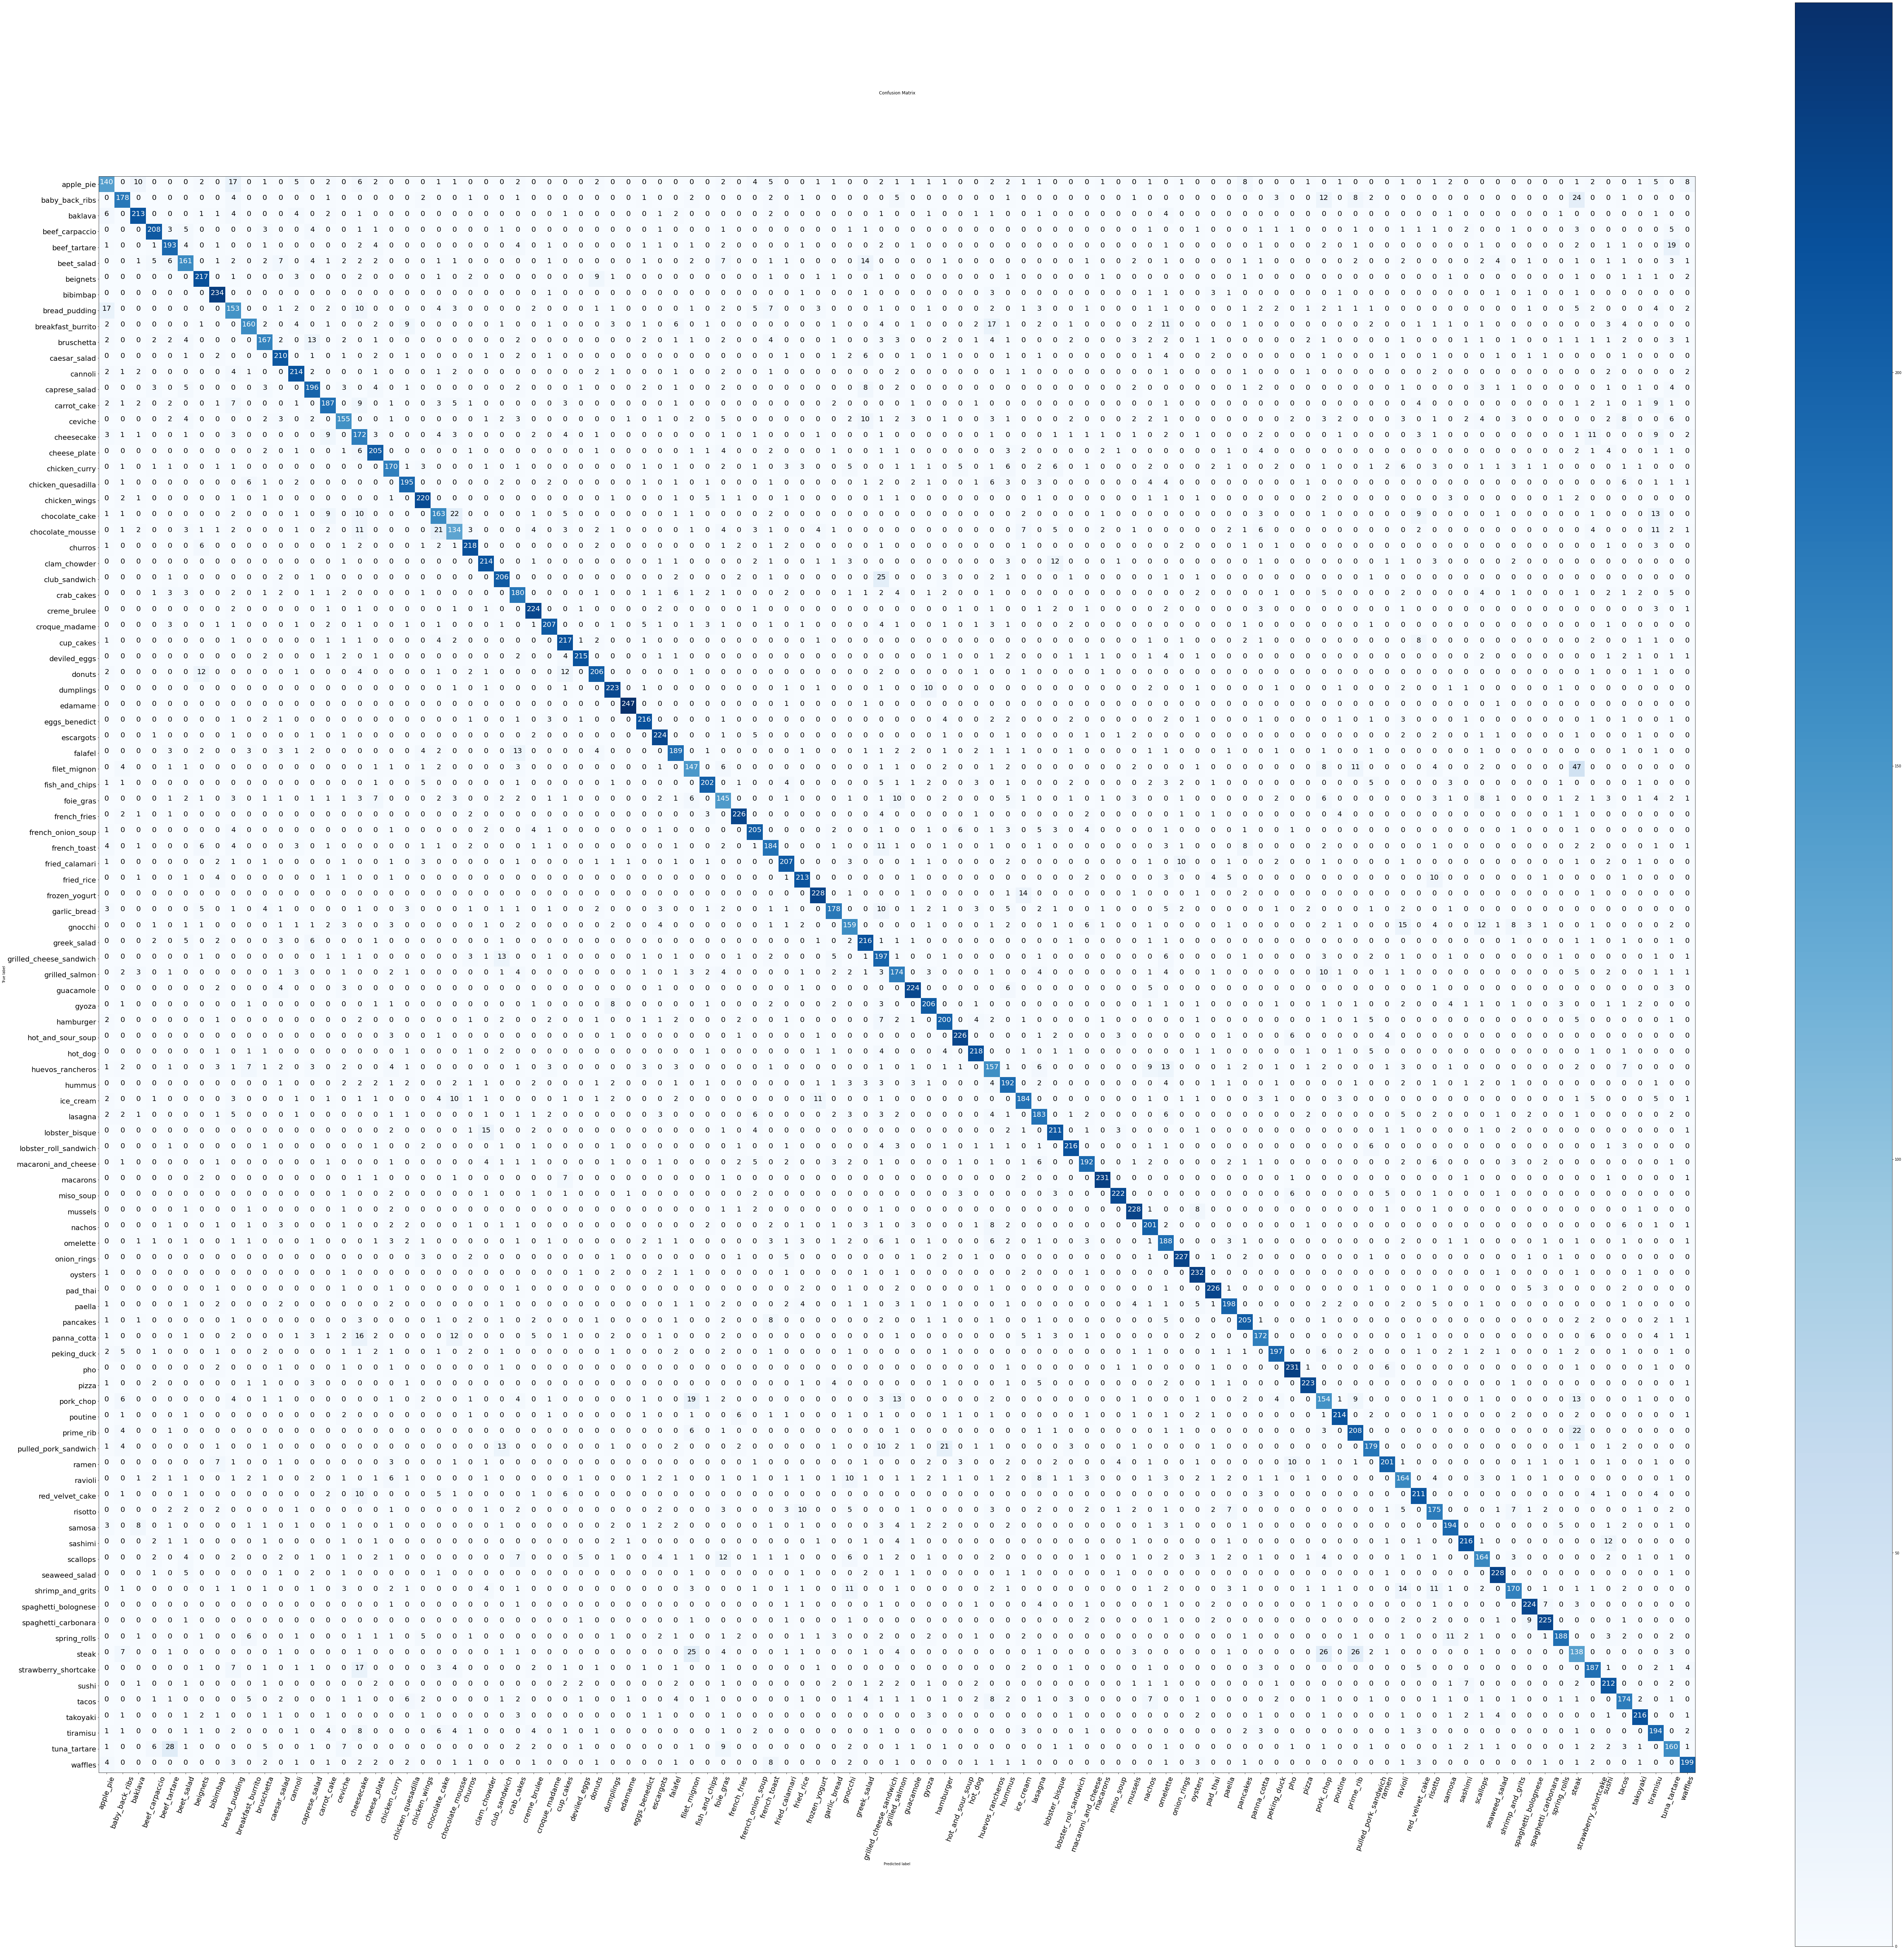

In [54]:
make_confusion_matrix(y_true, y_preds, class_names, figsize=(100,100), text_size=20)

In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.65      0.56      0.60       250
           1       0.76      0.71      0.74       250
           2       0.85      0.85      0.85       250
           3       0.85      0.83      0.84       250
           4       0.74      0.77      0.75       250
           5       0.72      0.64      0.68       250
           6       0.83      0.87      0.85       250
           7       0.84      0.94      0.88       250
           8       0.60      0.61      0.60       250
           9       0.81      0.64      0.72       250
          10       0.77      0.67      0.71       250
          11       0.81      0.84      0.82       250
          12       0.83      0.86      0.84       250
          13       0.77      0.78      0.78       250
          14       0.78      0.75      0.76       250
          15       0.72      0.62      0.67       250
          16       0.55      0.69      0.61       250
          17       0.79    

In [56]:
# Get a dictionary of classification report

classification_report_dict = classification_report(y_true, y_preds, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.6034482758620691,
  'precision': 0.6542056074766355,
  'recall': 0.56,
  'support': 250},
 '1': {'f1-score': 0.7370600414078674,
  'precision': 0.7639484978540773,
  'recall': 0.712,
  'support': 250},
 '10': {'f1-score': 0.7136752136752136,
  'precision': 0.7660550458715596,
  'recall': 0.668,
  'support': 250},
 '100': {'f1-score': 0.8089430894308943,
  'precision': 0.8223140495867769,
  'recall': 0.796,
  'support': 250},
 '11': {'f1-score': 0.8235294117647058,
  'precision': 0.8076923076923077,
  'recall': 0.84,
  'support': 250},
 '12': {'f1-score': 0.844181459566075,
  'precision': 0.8326848249027238,
  'recall': 0.856,
  'support': 250},
 '13': {'f1-score': 0.7793240556660039,
  'precision': 0.7747035573122529,
  'recall': 0.784,
  'support': 250},
 '14': {'f1-score': 0.7648261758691207,
  'precision': 0.7824267782426778,
  'recall': 0.748,
  'support': 250},
 '15': {'f1-score': 0.668103448275862,
  'precision': 0.7242990654205608,
  'recall': 0.62,
  'suppo

In [57]:
# Create empty dictionary
class_f1_scores ={}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
    if k == "accuracy":      # Stop once we get to accuracy
        break
    else:
        # Add class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

{'apple_pie': 0.6034482758620691,
 'baby_back_ribs': 0.7370600414078674,
 'baklava': 0.8486055776892429,
 'beef_carpaccio': 0.8421052631578947,
 'beef_tartare': 0.75390625,
 'beet_salad': 0.6778947368421052,
 'beignets': 0.8460038986354775,
 'bibimbap': 0.8846880907372401,
 'bread_pudding': 0.6047430830039525,
 'breakfast_burrito': 0.7158836689038032,
 'bruschetta': 0.7136752136752136,
 'caesar_salad': 0.8235294117647058,
 'cannoli': 0.844181459566075,
 'caprese_salad': 0.7793240556660039,
 'carrot_cake': 0.7648261758691207,
 'ceviche': 0.668103448275862,
 'cheese_plate': 0.8070866141732284,
 'cheesecake': 0.6120996441281139,
 'chicken_curry': 0.7142857142857142,
 'chicken_quesadilla': 0.8091286307053943,
 'chicken_wings': 0.8678500986193294,
 'chocolate_cake': 0.6707818930041152,
 'chocolate_mousse': 0.5763440860215053,
 'churros': 0.8650793650793651,
 'clam_chowder': 0.8492063492063492,
 'club_sandwich': 0.8110236220472441,
 'crab_cakes': 0.7114624505928854,
 'creme_brulee': 0.864864

In [58]:
# Turn f1-score into dataframes for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-scores" : list(class_f1_scores.values())}).sort_values("f1-scores", ascending=False)

f1_scores

class_names  f1-scores
33           edamame   0.984064
63          macarons   0.933333
76             pizza   0.910204
64         miso_soup   0.909836
88     seaweed_salad   0.908367
..               ...        ...
0          apple_pie   0.603448
77         pork_chop   0.592308
39         foie_gras   0.581162
22  chocolate_mousse   0.576344
93             steak   0.492857

[101 rows x 2 columns]

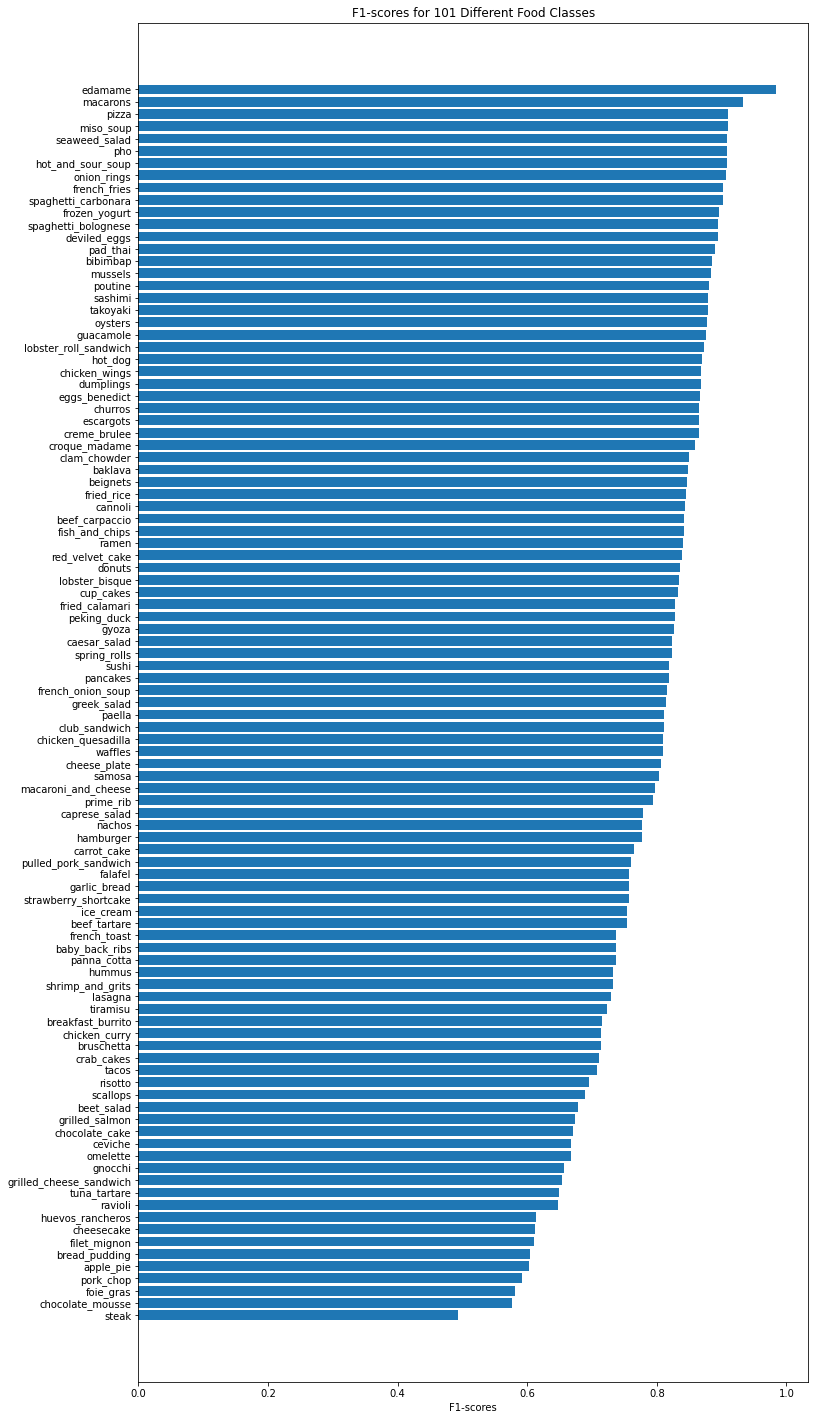

In [59]:
# plot the bar graph

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-scores'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1-scores')
ax.set_title('F1-scores for 101 Different Food Classes')
ax.invert_yaxis()
plt.show();

In [60]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_size=(224,224), scale=True):
    # Read in the image
    img = tf.io.read_file(filename)

    # Decode image into tensor
    img = tf.io.decode_image(img, channels=3)

    # Resize the image
    img = tf.image.resize(img, img_size)

    # Scale? Yes/no
    if scale:
        return img/255.
    else:
        return img     # For EfficientNet models in TensorFlow

In [61]:
# # Make preds on series of random images
# import os
# import random

# plt.figure(figsize=(17, 10), tight_layout=True)
# for i in range(3):
#     # Choose a random image from a random class
#     class_name = random.choice(class_names)
#     filename = random.choice(os.listdir(test_dir + class_name))
#     filepath = test_dir + class_name + '/' + filename

#     # Load the image and make prediction
#     img = load_and_prep_image(filepath, scale=False)
#     pred_prob = model.predict(tf.expand_dims(img, axis=0))  # get prediction probability array
#     pred_class = class_names[pred_prob.argmax()]       # get index of highest prediction and match it to classname list
    
#     # Plot the images
#     plt.subplot(1, 3, i+1)
#     plt.imshow(img/255.)
#     if class_name == pred_class:
#         title_color = 'g'
#     else:
#         title_color = 'r'

#     plt.title(f"Predicted: {pred_class} | True: {class_name} | Prob: {pred_prob.max():.2f}", c=title_color, fontsize=12)
#     plt.axis(False);

In [62]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({'y_true': y_true,
                        'pred_classes': y_preds,
                        'pred_conf': probs.max(axis=1),
                        'y_true_class_names' : [class_names[i] for i in y_true],
                        'y_pred_class_name' : [class_names[i] for i in y_preds]})
pred_df

y_true  pred_classes  ...   y_true_class_names    y_pred_class_name
0          29            29  ...            cup_cakes            cup_cakes
1          81            81  ...                ramen                ramen
2          91            91  ...  spaghetti_carbonara  spaghetti_carbonara
3          53            53  ...            hamburger            hamburger
4          97            97  ...             takoyaki             takoyaki
...       ...           ...  ...                  ...                  ...
25245      38            38  ...       fish_and_chips       fish_and_chips
25246      86            86  ...              sashimi              sashimi
25247      76            46  ...                pizza         garlic_bread
25248      31            31  ...               donuts               donuts
25249      21            21  ...       chocolate_cake       chocolate_cake

[25250 rows x 5 columns]

In [63]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['pred_classes']

pred_df.head()

y_true  pred_classes  ...    y_pred_class_name pred_correct
0      29            29  ...            cup_cakes         True
1      81            81  ...                ramen         True
2      91            91  ...  spaghetti_carbonara         True
3      53            53  ...            hamburger         True
4      97            97  ...             takoyaki         True

[5 rows x 6 columns]

In [64]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong.head(20)

y_true  pred_classes  ...  y_pred_class_name pred_correct
15437      56            66  ...             nachos        False
13884      46            10  ...         bruschetta        False
9735       87            30  ...       deviled_eggs        False
900        14            29  ...          cup_cakes        False
7455       43            68  ...        onion_rings        False
17440      23            68  ...        onion_rings        False
14234      52            32  ...          dumplings        False
6717       31            29  ...          cup_cakes        False
7659       68            70  ...           pad_thai        False
15071      85            92  ...       spring_rolls        False
22323      64            54  ...  hot_and_sour_soup        False
20931      93            39  ...          foie_gras        False
2225       43            20  ...      chicken_wings        False
19665      19             9  ...  breakfast_burrito        False
16129      65            69  ...            oysters        False
810         5            11  ...       caesar_salad        False
22788      63            29  ...          cup_cakes        False
4239       13            97  ...           takoyaki        False
1113       72            67  ...           omelette        False
3182       21            83  ...    red_velvet_cake        False

[20 rows x 6 columns]

In [65]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2021-07-05 17:10:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  83.5MB/s    in 0.2s    

2021-07-05 17:10:09 (83.5 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [66]:
from helper_functions import unzip_data
unzip_data('custom_food_images.zip')

In [67]:
# Get custom food images filepaths
import glob
custom_food_images = []
for filepath in sorted(glob.glob('custom_food_images/*')):
    custom_food_images.append(filepath)

custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg']

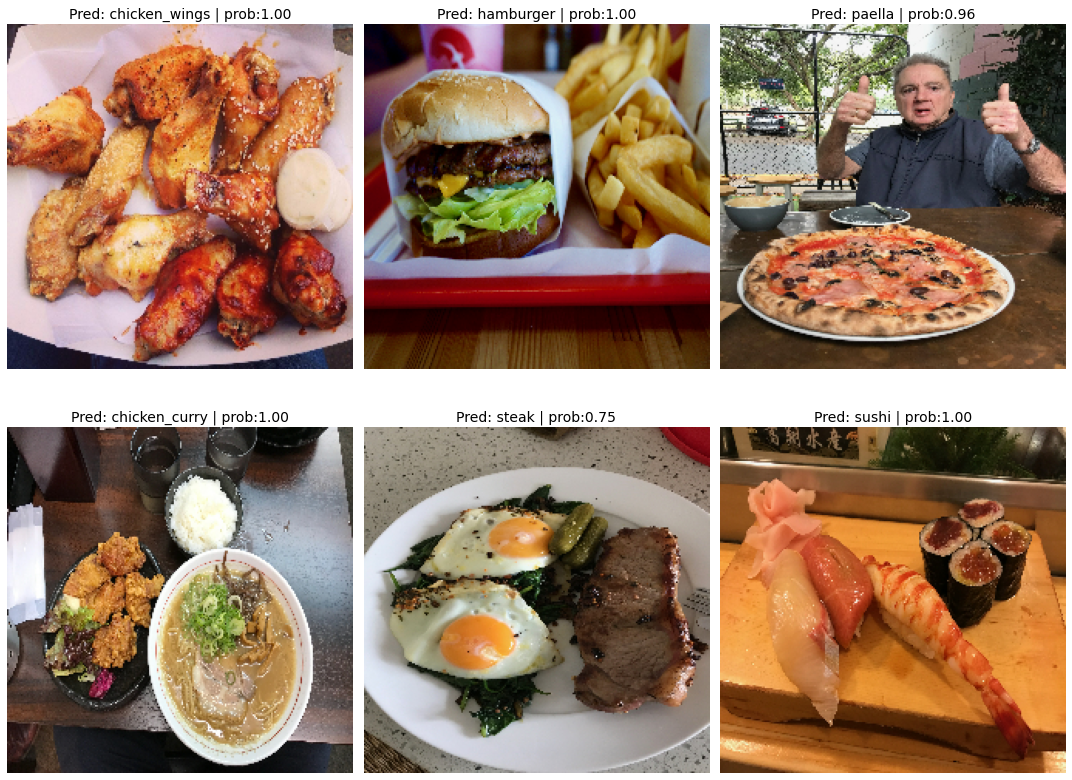

In [68]:
# Make prediction on and plot custom food images
plt.figure(figsize=(15,13), tight_layout=True)
for i, img in enumerate(custom_food_images):
    plt.subplot(2, 3, i+1)
    
    img = load_and_prep_image(img, scale=False)
    y_prob = loaded_model.predict(tf.expand_dims(img, axis=0))
    y_pred_class = class_names[y_prob.argmax()]

    # Plot the appropiate information
    plt.imshow(img/255.)
    plt.title(f"Pred: {y_pred_class} | prob:{y_prob.max():.2f}", fontsize=14)
    plt.axis(False);

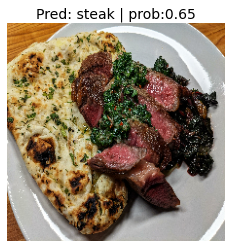

In [69]:
img = load_and_prep_image('/content/steak.jpg', scale=False)
y_prob = loaded_model.predict(tf.expand_dims(img, axis=0))
y_pred_class = class_names[y_prob.argmax()]

# Plot the appropiate information
plt.imshow(img/255.)
plt.title(f"Pred: {y_pred_class} | prob:{y_prob.max():.2f}", fontsize=14)
plt.axis(False);

### Saving Fine tune model


In [70]:
loaded_model.save('/content/drive/MyDrive/Food-Vision-EfficientNetB0')     # Saving model in .pb format

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food-Vision-EfficientNetB0/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food-Vision-EfficientNetB0/assets


In [71]:
loaded_model.save('/content/drive/MyDrive/FoodVision-EfficientNetB0.h5')